# Forecasting bike usage in Berlin
1. EDA
2. Preparing and cleansing data
3. Forecast data
   1. using Gradient Boosting Tree
   2. using Meta's Prophet

## Import packages and data

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

I read in the data I processed through the `transform_excel.ipynb` notebook and through SQL.

In [3]:
data = pd.read_csv("../data/data_all_years.csv", parse_dates=[0])

## EDA
Nothing special here just some checks on errors, outliers and dimensions. So, I get a better impression of the data.

In [4]:
# Print some samples
data.tail()

,DateTime,station,cyclists
1211302,2017-12-29 06:00:00,schw,12
1211303,2017-12-29 06:00:00,yoro,12
1211304,2017-12-29 06:00:00,yorw,18
1211305,2017-12-29 07:00:00,albe,4
1211306,2017-12-29 07:00:00,bern,73


In [5]:
# Check data types and data dimensions
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211307 entries, 0 to 1211306
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   DateTime  1211307 non-null  datetime64[ns]
 1   station   1211307 non-null  object        
 2   cyclists  1211307 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 27.7+ MB


In [6]:
# Looking at some statistical measures
data.describe(include='all', datetime_is_numeric=True)

,DateTime,station,cyclists
count,1211307,1211307,1.211307e+06
unique,NaN,26,NaN
top,NaN,schw,NaN
freq,NaN,77466,NaN
mean,2018-04-10 15:15:56.587554048,NaN,9.014837e+01
min,2012-03-01 00:00:00,NaN,-1.000000e+00
25%,2017-01-05 22:00:00,NaN,1.100000e+01
50%,2018-05-06 05:00:00,NaN,4.600000e+01
75%,2019-09-03 13:00:00,NaN,1.270000e+02
max,2020-12-31 23:00:00,NaN,2.167000e+03


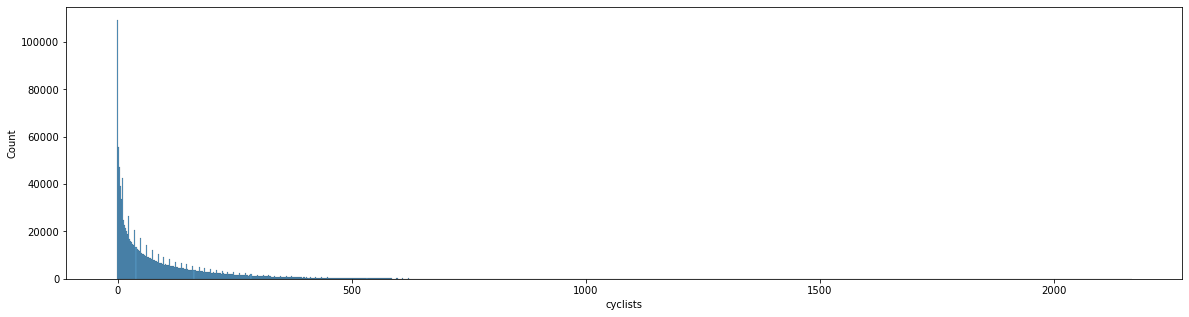

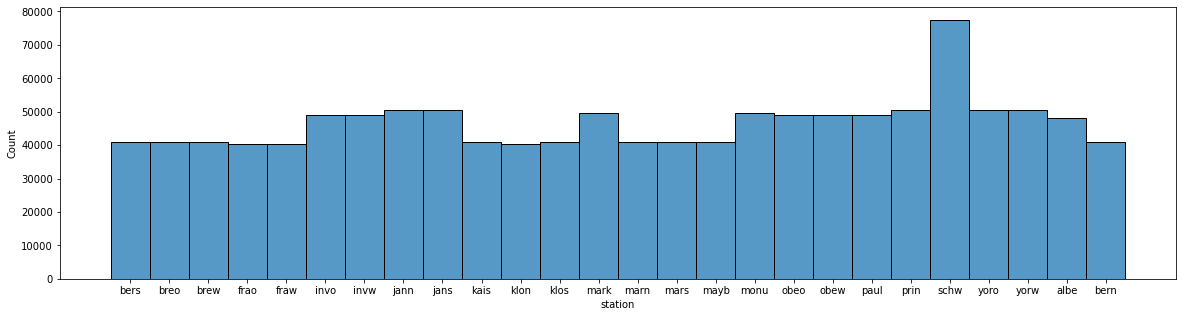

<AxesSubplot:xlabel='DateTime', ylabel='Count'>

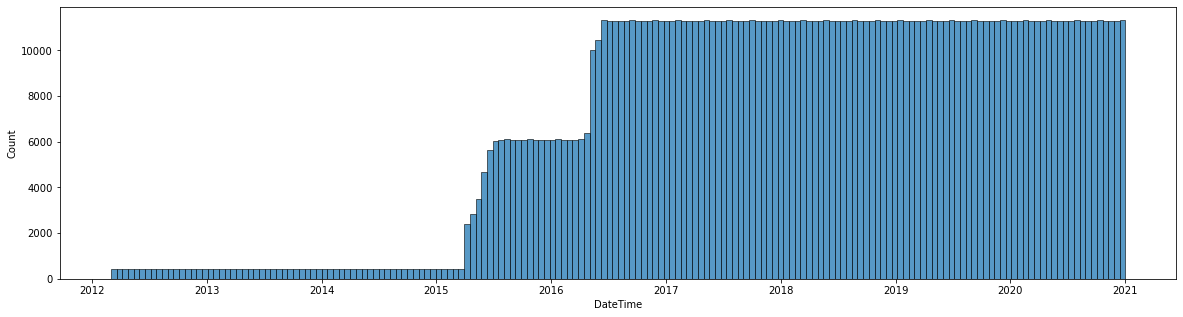

In [7]:
# Look at the distribution of data
plt.figure(figsize=(20,5))
sns.histplot(data=data, x='cyclists')
plt.show()
plt.figure(figsize=(20,5))
sns.histplot(data=data, x='station')
plt.show()
plt.figure(figsize=(20,5))
sns.histplot(data=data, x='DateTime')

### Missing values
check for missing values. There should be no missing values as I filtered them out in SQL. 

In [8]:
data.isna().sum()


DateTime    0
station     0
cyclists    0
dtype: int64

### Errors
In contrast of missing values, there are many error values. I delete them so that I can see how many usabel data I have for each station.

C:\Users\Philip Singer\AppData\Local\Temp\ipykernel_14104\2349416369.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  amount_of_measurements = amount_of_measurements.append({'station':i, 'count':data[(data['station'] == i) & (data['cyclists'] == -1)].shape[0]}, ignore_index=True)
C:\Users\Philip Singer\AppData\Local\Temp\ipykernel_14104\2349416369.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  amount_of_measurements = amount_of_measurements.append({'station':i, 'count':data[(data['station'] == i) & (data['cyclists'] == -1)].shape[0]}, ignore_index=True)
C:\Users\Philip Singer\AppData\Local\Temp\ipykernel_14104\2349416369.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  amount_of_measurements = amount_of_measureme

<AxesSubplot:xlabel='count', ylabel='station'>

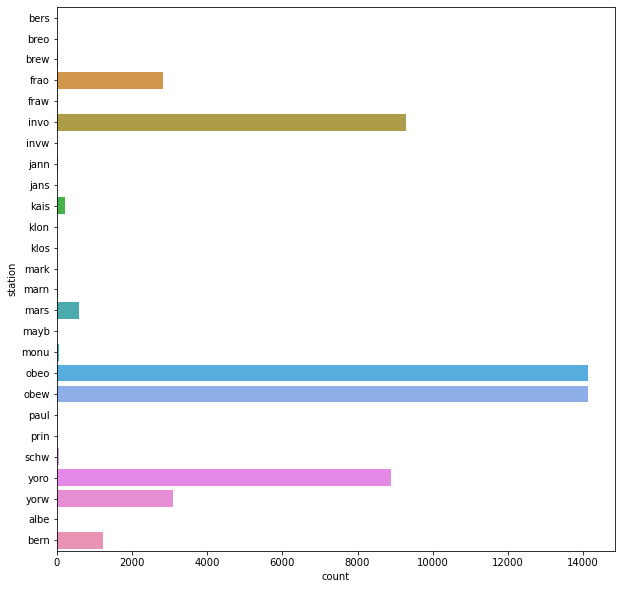

In [9]:
# counting values for each station
amount_of_measurements = pd.DataFrame(columns=['station', 'count'])
for i in data['station'].unique():
    amount_of_measurements = amount_of_measurements.append({'station':i, 'count':data[(data['station'] == i) & (data['cyclists'] == -1)].shape[0]}, ignore_index=True)

plt.figure(figsize=(10, 10))
sns.barplot(data=amount_of_measurements, x='count', y='station')

As you can see, there are a lot of errors. We remove them in the next step.

#### Cleaning errors

In [10]:
data_clean = data
data_clean.loc[data.cyclists == -1, 'cyclists'] = np.nan
data_clean.dropna(inplace=True)

### Outliers
As you can see in the box plot below, there are some outliers. But because I will sum the hourly data up to daily measurements I won't clean them now. 

<AxesSubplot:xlabel='station', ylabel='cyclists'>

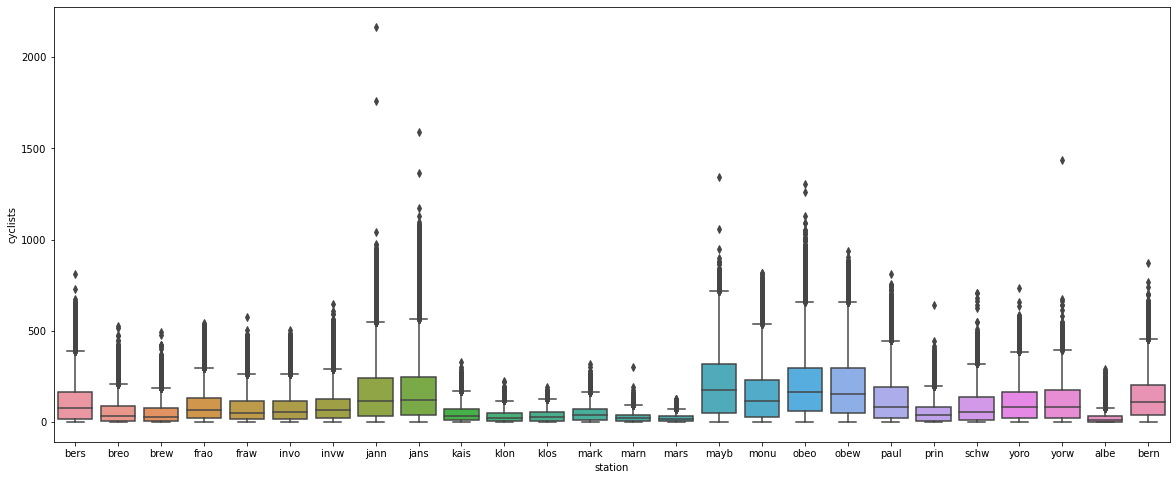

In [11]:
plt.figure(figsize=(20,8))
sns.boxplot(data=data, y='cyclists', x="station")

Counting usable values for each station


C:\Users\Philip Singer\AppData\Local\Temp\ipykernel_14104\4264998814.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  amount_of_measurements = amount_of_measurements.append({'station':i, 'count':data[data['station'] == i].shape[0]}, ignore_index=True)
C:\Users\Philip Singer\AppData\Local\Temp\ipykernel_14104\4264998814.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  amount_of_measurements = amount_of_measurements.append({'station':i, 'count':data[data['station'] == i].shape[0]}, ignore_index=True)
C:\Users\Philip Singer\AppData\Local\Temp\ipykernel_14104\4264998814.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  amount_of_measurements = amount_of_measurements.append({'station':i, 'count':data[data['station'] == i

<AxesSubplot:xlabel='count', ylabel='station'>

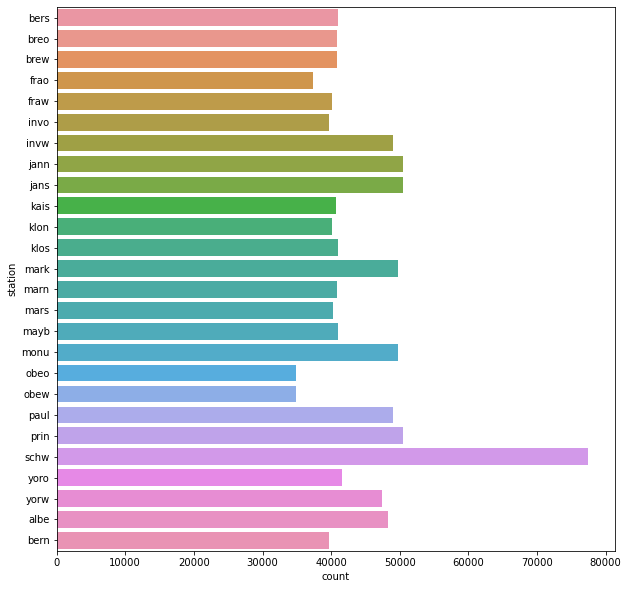

In [12]:
amount_of_measurements = pd.DataFrame(columns=['station', 'count'])
for i in data['station'].unique():
    amount_of_measurements = amount_of_measurements.append({'station':i, 'count':data[data['station'] == i].shape[0]}, ignore_index=True)

plt.figure(figsize=(10, 10))
sns.barplot(data=amount_of_measurements, x='count', y='station')

## Prepare the data
I augment the records by calculated information  
- weekend
- bank holiday
- winter or summer

I will handle the forecasting challenge as a regression task. Therefore, I will split the date in its components.  
As I want to have the prediction on a daily level, I will group all data per day by sum.

In [13]:
data_augmented = data_clean.copy()
weekend_list = []
for row_weekday in data_augmented['DateTime']:
    if row_weekday.weekday() >= 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)
data_augmented['weekend'] = weekend_list

In [14]:
summer_list = [1 if date.month >= 3 and date.month <= 10 else 0 for date in data_augmented['DateTime']]
data_augmented['summer'] = summer_list

In [15]:
data_augmented.head()

,DateTime,station,cyclists,weekend,summer
0,2017-12-29 07:00:00,bers,32.0,0,0
1,2017-12-29 07:00:00,breo,18.0,0,0
2,2017-12-29 07:00:00,brew,14.0,0,0
3,2017-12-29 07:00:00,frao,14.0,0,0
4,2017-12-29 07:00:00,fraw,16.0,0,0


In [16]:
import requests

url = "https://feiertage-api.de/api/?nur_land=BE&jahr="
response = []

for year in range(2012, 2021):
    year_response = requests.request("GET", url+str(year)).json()
    for holiday in year_response:
        response.append(year_response[holiday]["datum"])

print(response)

['2012-01-01', '2012-04-06', '2012-04-09', '2012-05-01', '2012-05-17', '2012-05-28', '2012-10-03', '2012-12-25', '2012-12-26', '2013-01-01', '2013-03-29', '2013-04-01', '2013-05-01', '2013-05-09', '2013-05-20', '2013-10-03', '2013-12-25', '2013-12-26', '2014-01-01', '2014-04-18', '2014-04-21', '2014-05-01', '2014-05-29', '2014-06-09', '2014-10-03', '2014-12-25', '2014-12-26', '2015-01-01', '2015-04-03', '2015-04-06', '2015-05-01', '2015-05-14', '2015-05-25', '2015-10-03', '2015-12-25', '2015-12-26', '2016-01-01', '2016-03-25', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16', '2016-10-03', '2016-12-25', '2016-12-26', '2017-01-01', '2017-04-14', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-05', '2017-10-03', '2017-10-31', '2017-12-25', '2017-12-26', '2018-01-01', '2018-03-30', '2018-04-02', '2018-05-01', '2018-05-10', '2018-05-21', '2018-10-03', '2018-12-25', '2018-12-26', '2019-01-01', '2019-03-08', '2019-04-19', '2019-04-22', '2019-05-01', '2019-05-30', '2019-06-10', '2019

In [17]:
data_augmented['bank_holiday'] = [1 if str(date.date()) in response else 0 for date in data_augmented["DateTime"]]

In [18]:
data_mean = data_augmented.copy()
data_mean["Day"] = data_mean["DateTime"].dt.day.map("{:02}".format)
data_mean["Month"] = data_mean["DateTime"].dt.month.map("{:02}".format)
data_mean["Year"] = data_mean["DateTime"].dt.year
data_mean["min"] = data_mean["DateTime"].dt.hour
data_mean.drop("DateTime", axis=1, inplace=True)

get_first = lambda col: col.head(1)

data_mean = data_mean\
    .groupby(by=["Year", "Month", "Day", "station"], as_index=False)\
    .agg({'cyclists': 'sum', 'bank_holiday': get_first, 'weekend': get_first, 'summer': get_first})


In [19]:
data_mean.head()

,Year,Month,Day,station,cyclists,bank_holiday,weekend,summer
0,2012,03,01,schw,1086.0,0,0,1
1,2012,03,02,schw,1164.0,0,0,1
2,2012,03,03,schw,1247.0,0,0,1
3,2012,03,04,schw,1327.0,0,1,1
4,2012,03,05,schw,1356.0,0,0,1


### Revisit the outliers
We check again for outliers. There are only a few and removing them would effect only a small performance increase.

<AxesSubplot:xlabel='station', ylabel='cyclists'>

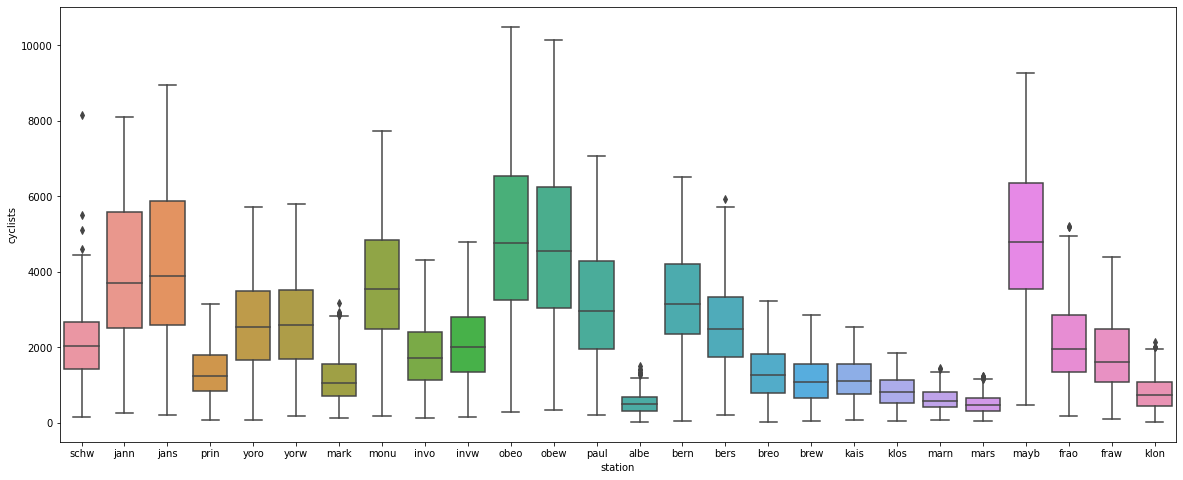

In [20]:
plt.figure(figsize=(20,8))
sns.boxplot(data=data_mean, y='cyclists', x="station")

## Develop Forecasting Model
### Regression Model

I will train a model for every station. So, I don't have to encode the station name and I can leave this column out.  
This example will be with station `schw`. 

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import datetime


Create train and test set

In [22]:
station = "schw"

train_X = data_mean.loc[data_mean["station"] == station,["Year", "Month", "Day", "bank_holiday", "weekend", "summer"]]
train_X = train_X.iloc[:int(train_X.shape[0]*0.9)].astype(int)
train_y = data_mean.loc[data_mean["station"] == station,["cyclists"]]
train_y = train_y.iloc[:int(train_y.shape[0]*0.9)].astype(int)

test_X = data_mean.loc[data_mean["station"] == station,["Year", "Month", "Day", "bank_holiday", "weekend", "summer"]]
test_X = test_X.iloc[int(test_X.shape[0]*0.9):].astype(int)
test_y = data_mean.loc[data_mean["station"] == station,["cyclists"]]
test_y = test_y.iloc[int(test_y.shape[0]*0.9):].astype(int)

First, I try to find the best hyperparameter by using Randomized Search.

In [23]:
training = False
if training:
    param_grid = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],
                    'n_estimators':[100,250,500,750,1000,1250,1500,1750],
                    'max_depth':[2,3,4,5,6,7],
                    'min_samples_split':[2,4,6,8,10,20,40,60,100], 
                    'min_samples_leaf':[1,3,5,7,9],
                    'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
        }
    clf = RandomizedSearchCV(GradientBoostingRegressor(random_state=123), n_iter=20, n_jobs=-1, param_distributions=param_grid, scoring='neg_mean_squared_error', verbose=0, random_state=123)
    clf.fit(train_X, train_y)
    print(clf.best_params_)


Then train the model with found hyperparameters and validate the model with some metrics.

In [24]:
gbr = GradientBoostingRegressor(
    random_state=123, 
    subsample=0.85,
    n_estimators=1250,
    min_samples_split=8,
    min_samples_leaf=1, 
    max_depth=3,
    learning_rate=0.005,
)

gbr.fit(train_X, train_y)
pred_y = pd.DataFrame(gbr.predict(test_X))

def validate(test_y, pred_y):
    print("MSE", metrics.mean_squared_error(test_y, pred_y))
    print("RMSE", metrics.mean_squared_error(test_y, pred_y, squared=False))
    print("R2", metrics.r2_score(test_y, pred_y))
    print("MAPE", metrics.mean_absolute_percentage_error(test_y, pred_y))
    
validate(test_y, pred_y)

C:\Anaconda\envs\ds39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE 739218.3908721633
RMSE 859.778105601767
R2 0.07953268907066402
MAPE 0.27602791105348023


Let's compare the output of the model with the real values in a chart.

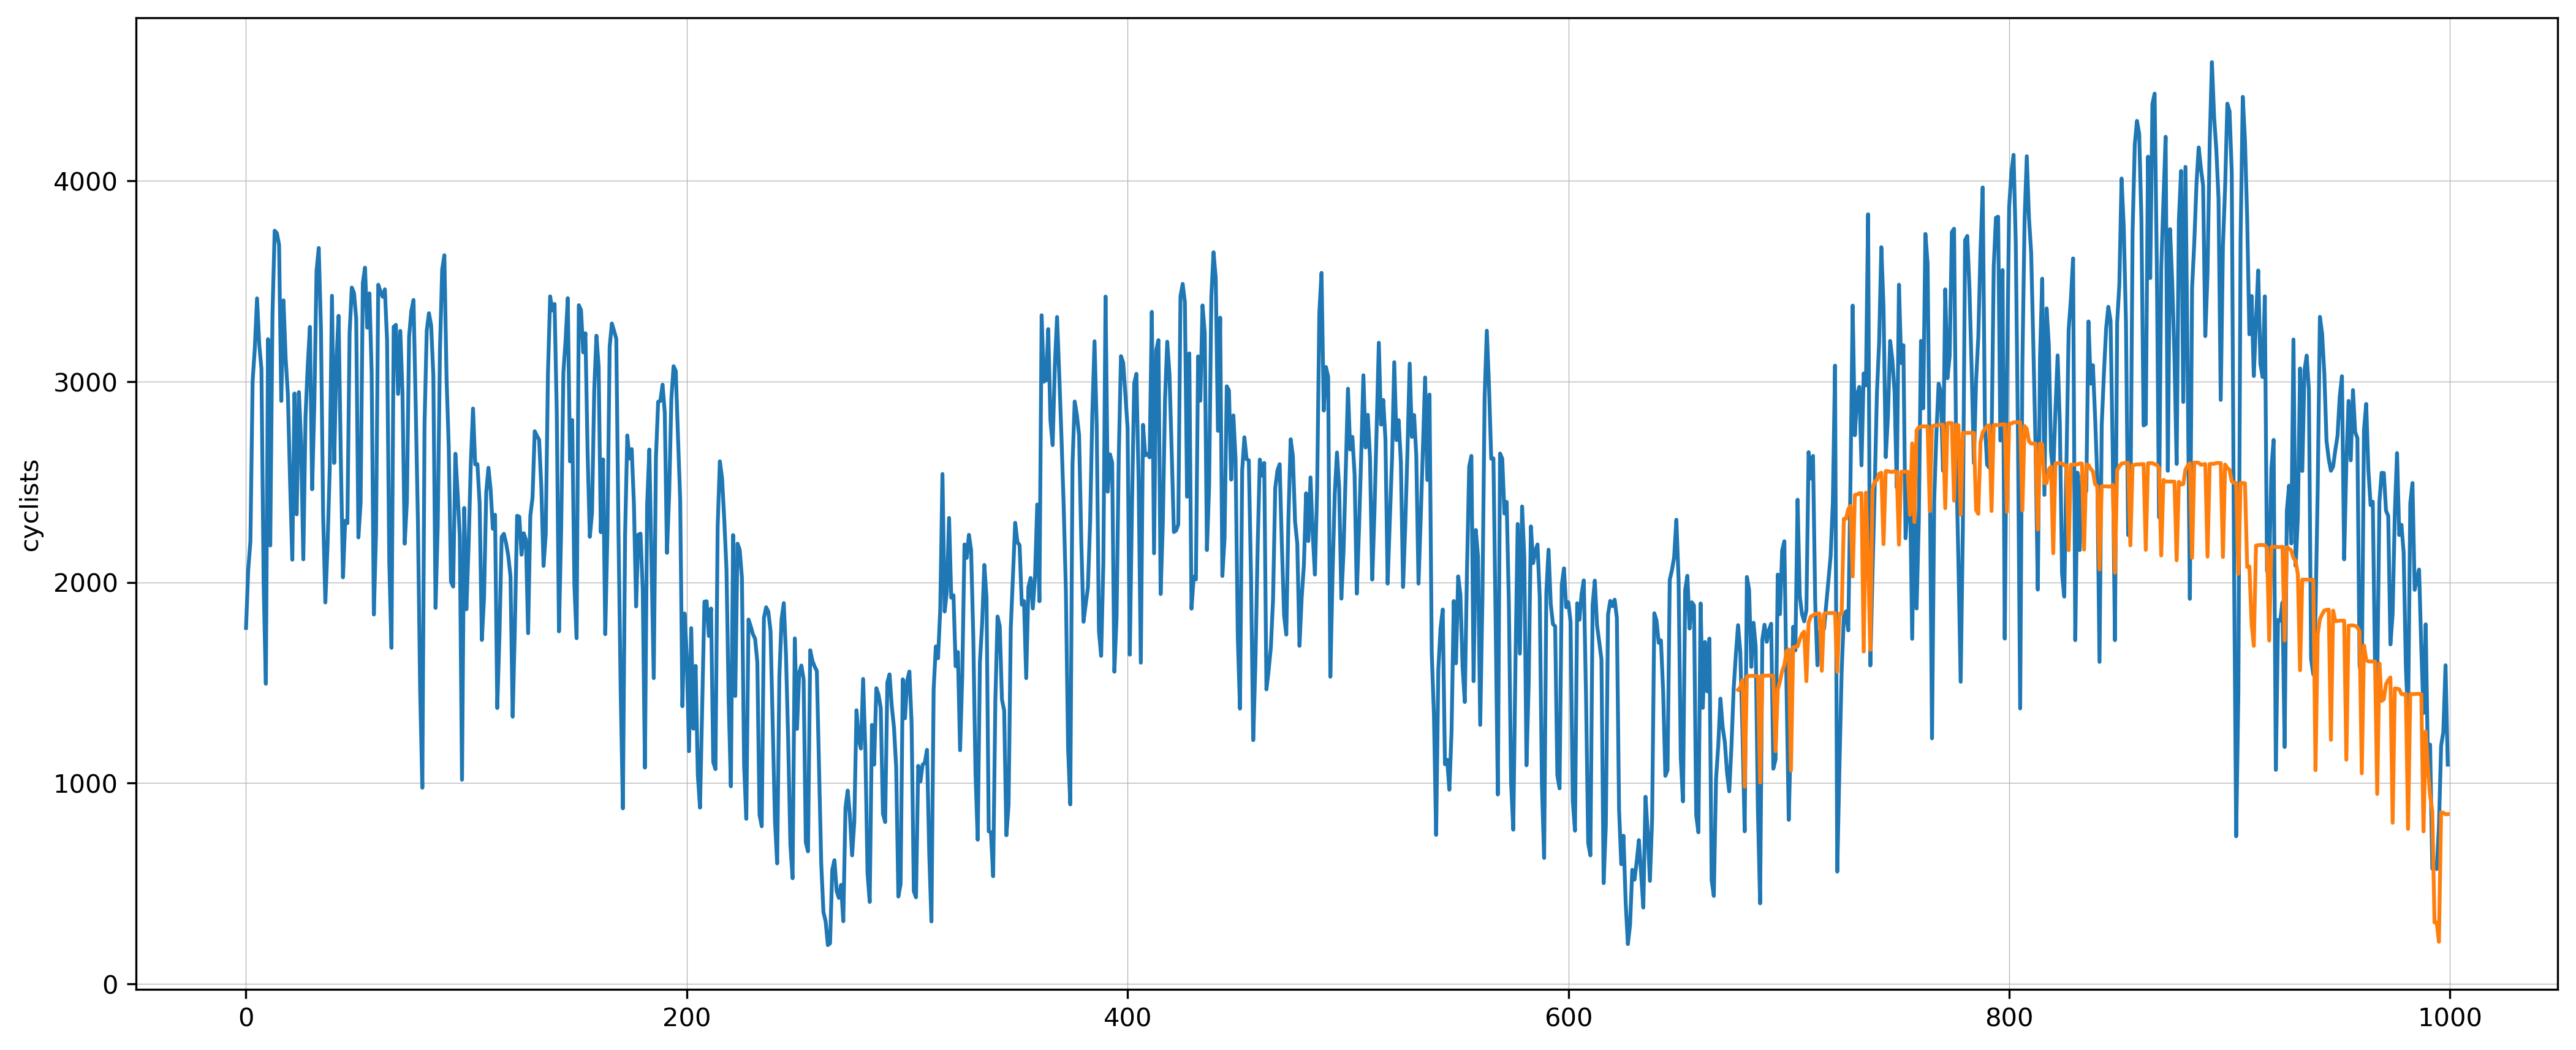

In [25]:
plt.rcParams.update({'figure.figsize': (17, 7), 'figure.dpi':300})
fig, ax = plt.subplots()
g = sns.lineplot(data=data_mean.loc[data_mean["station"] == station].tail(1000), y = 'cyclists', x=np.arange((data_mean.loc[data_mean["station"] == station].tail(1000).shape[0])))
sns.lineplot(data=pred_y, x=np.arange((1000-323), 1000), y=0)
plt.grid(linestyle='-', linewidth=0.3)

I find the MAPE metric is the most usable one because the real numbers are too big to evaluate the performance of the model. But also 24% mean error are not very good.  And you can see, that the model predict not high enough values and decreases the prediction too early.  

### Prophet Model
I want to try the Prophet API developed by Facebook (https://facebook.github.io/prophet/docs/quick_start.html). This is a "real" time-series/forecasting model, but it follows the API style of sklearn, so it's easier for me, as I am familiar with this API style.

In [26]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


Change dataframe columns to `ds` and `y`, so prophet can read that data.

In [27]:
station = "schw"
data_prophet_train = pd.DataFrame(columns=["ds", "y"])

data_prophet_train['ds'] = pd.to_datetime(pd.concat([data_mean.loc[data_mean["station"] == station,["Year"]],  
                                                    data_mean.loc[data_mean["station"] == station,["Month"]], 
                                                    data_mean.loc[data_mean["station"] == station, ["Day"]]], axis=1), format='%Y%m%d')
data_prophet_train['y'] = data_mean['cyclists']

data_prophet_test =  data_prophet_train.iloc[int(data_prophet_train.shape[0]*0.9):]['ds'].to_frame()
data_prophet_train = data_prophet_train.iloc[:int(data_prophet_train.shape[0]*0.9)]

print(data_prophet_train.shape)
print(data_prophet_test.shape)

(2903, 2)
(323, 1)


#### Fit the model and predict with the same test_data as before

In [28]:
model_prophet = Prophet()
model_prophet.fit(data_prophet_train)
forecast = model_prophet.predict(data_prophet_test)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Anaconda\envs\ds39\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Anaconda\envs\ds39\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Anaconda\envs\ds39\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


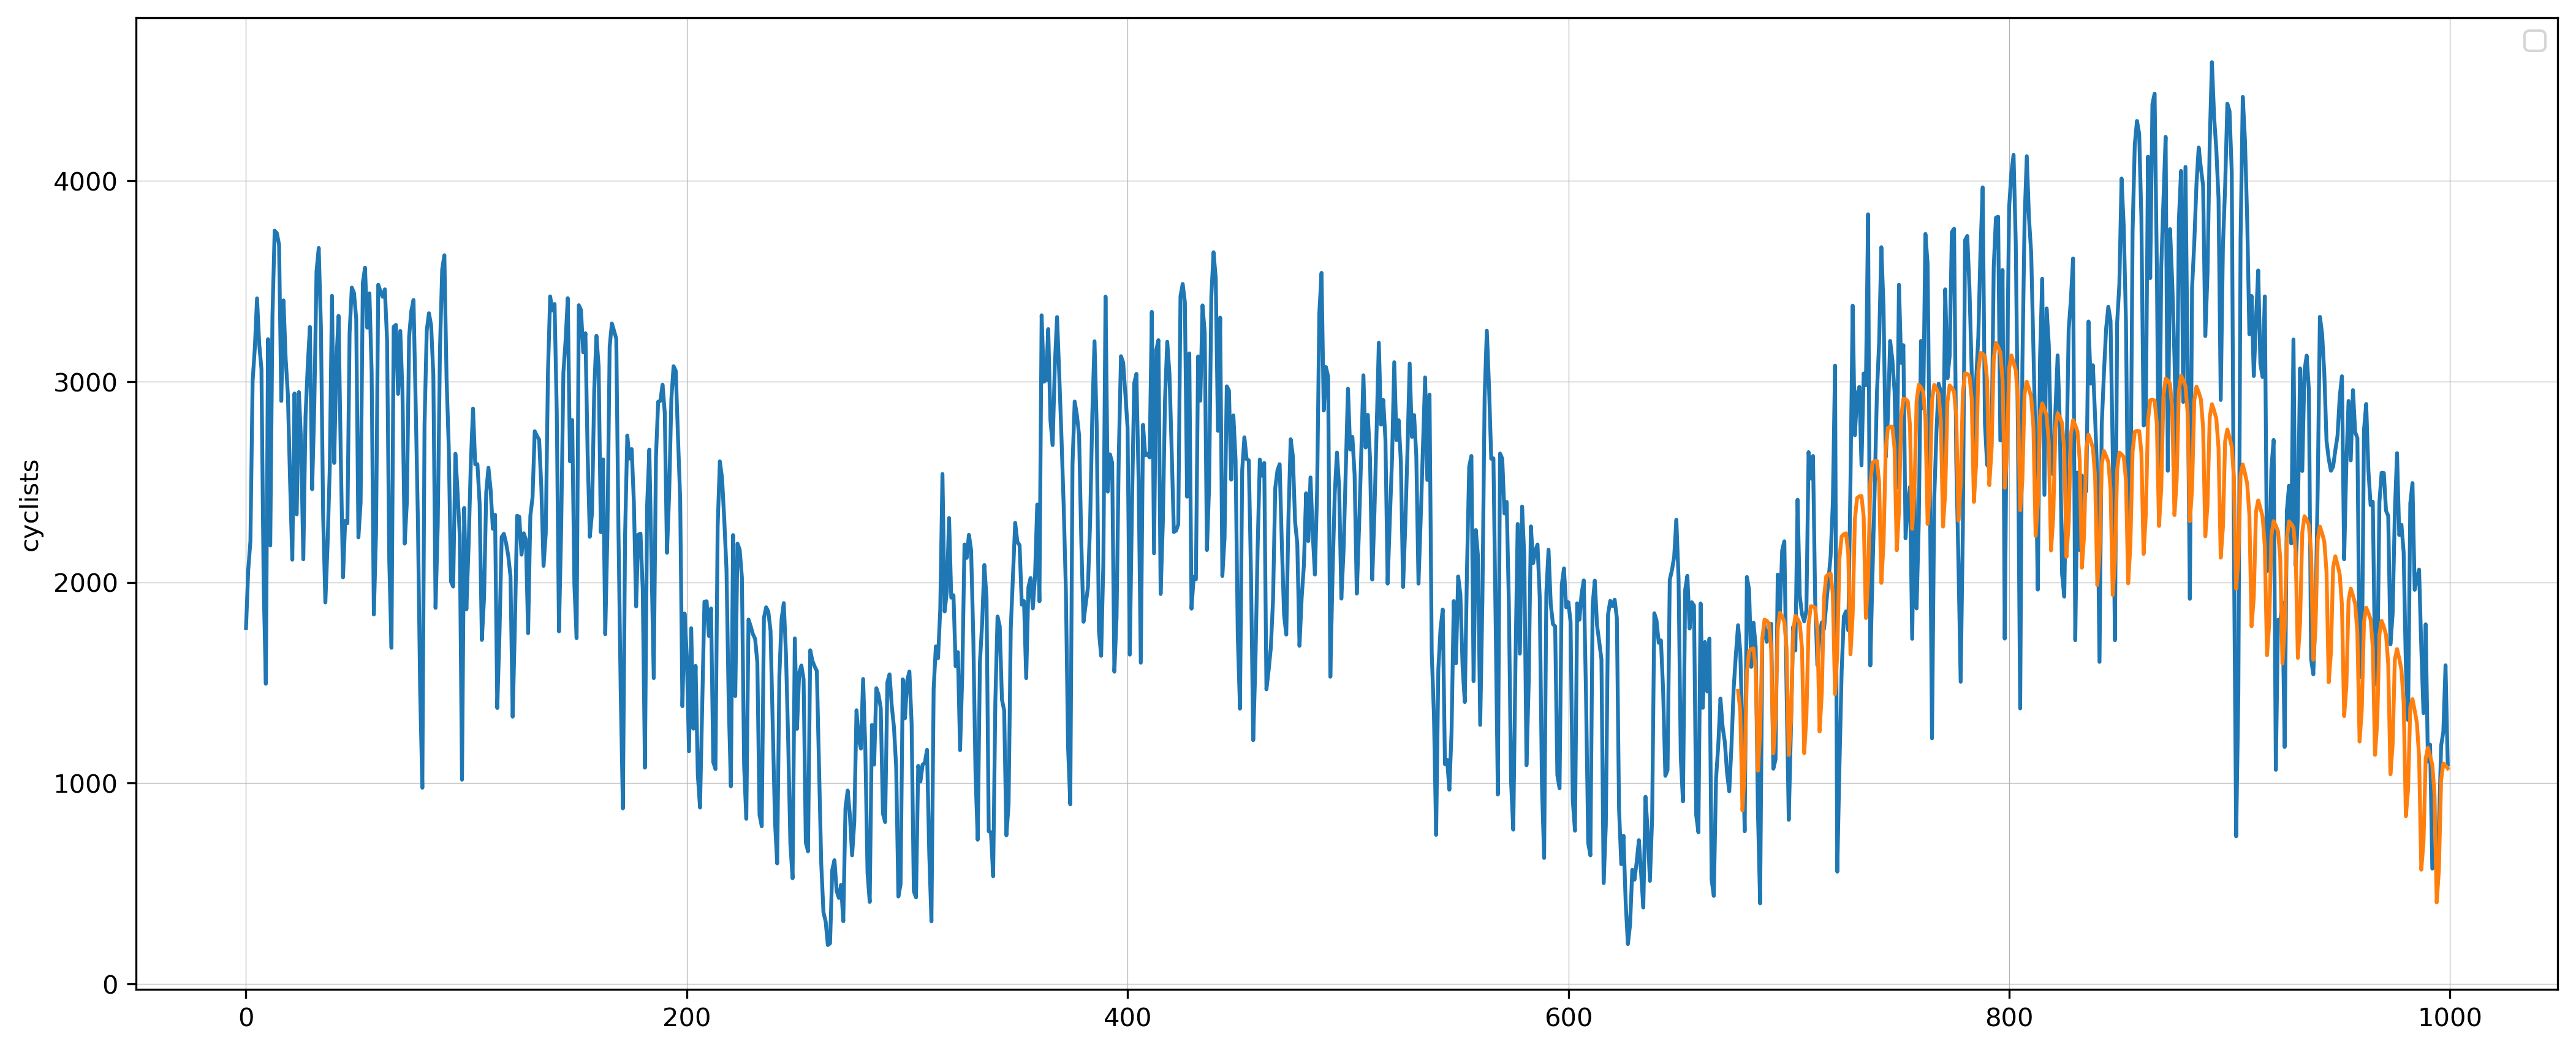

In [29]:
plt.rcParams.update({'figure.figsize': (17, 7), 'figure.dpi':300})
fig, ax = plt.subplots()
g = sns.lineplot(data=data_mean.loc[data_mean["station"] == station].tail(1000), y = 'cyclists', x=np.arange((data_mean.loc[data_mean["station"] == station].tail(1000).shape[0])))
sns.lineplot(data=forecast, x=np.arange((1000-323), 1000), y='yhat')
plt.grid(linestyle='-', linewidth=0.3)
plt.legend()

In [30]:
def validate(test_y, pred_y):
    print("MSE", metrics.mean_squared_error(test_y, pred_y))
    print("RMSE", metrics.mean_squared_error(test_y, pred_y, squared=False))
    print("R2", metrics.r2_score(test_y, pred_y))
    print("MAPE", metrics.mean_absolute_percentage_error(test_y, pred_y))
    
validate(test_y, forecast['yhat'])

MSE 575790.5435300084
RMSE 758.8086343275282
R2 0.2830314020782222
MAPE 0.2524585513644486


If you look at the MAPE the Prophet model is slightly better in predicting than the regression model. Generally, I think both models perform not that well, because the data in 2020 which is the test data here is not very similar to the previous years. Of course this is a bad excuse. But you can easily see that both models have the problem that they underestimate the number of cyclists in the summer of 2020. The uncommon amount of cyclists can be connected to the COVID-19 pandemic.

In the plot below you can see, that the line of 2020 differs from the line in the previous years (especially in comparison with 2012 until the beginning of 2018).

<AxesSubplot:xlabel='DateTime', ylabel='cyclists'>

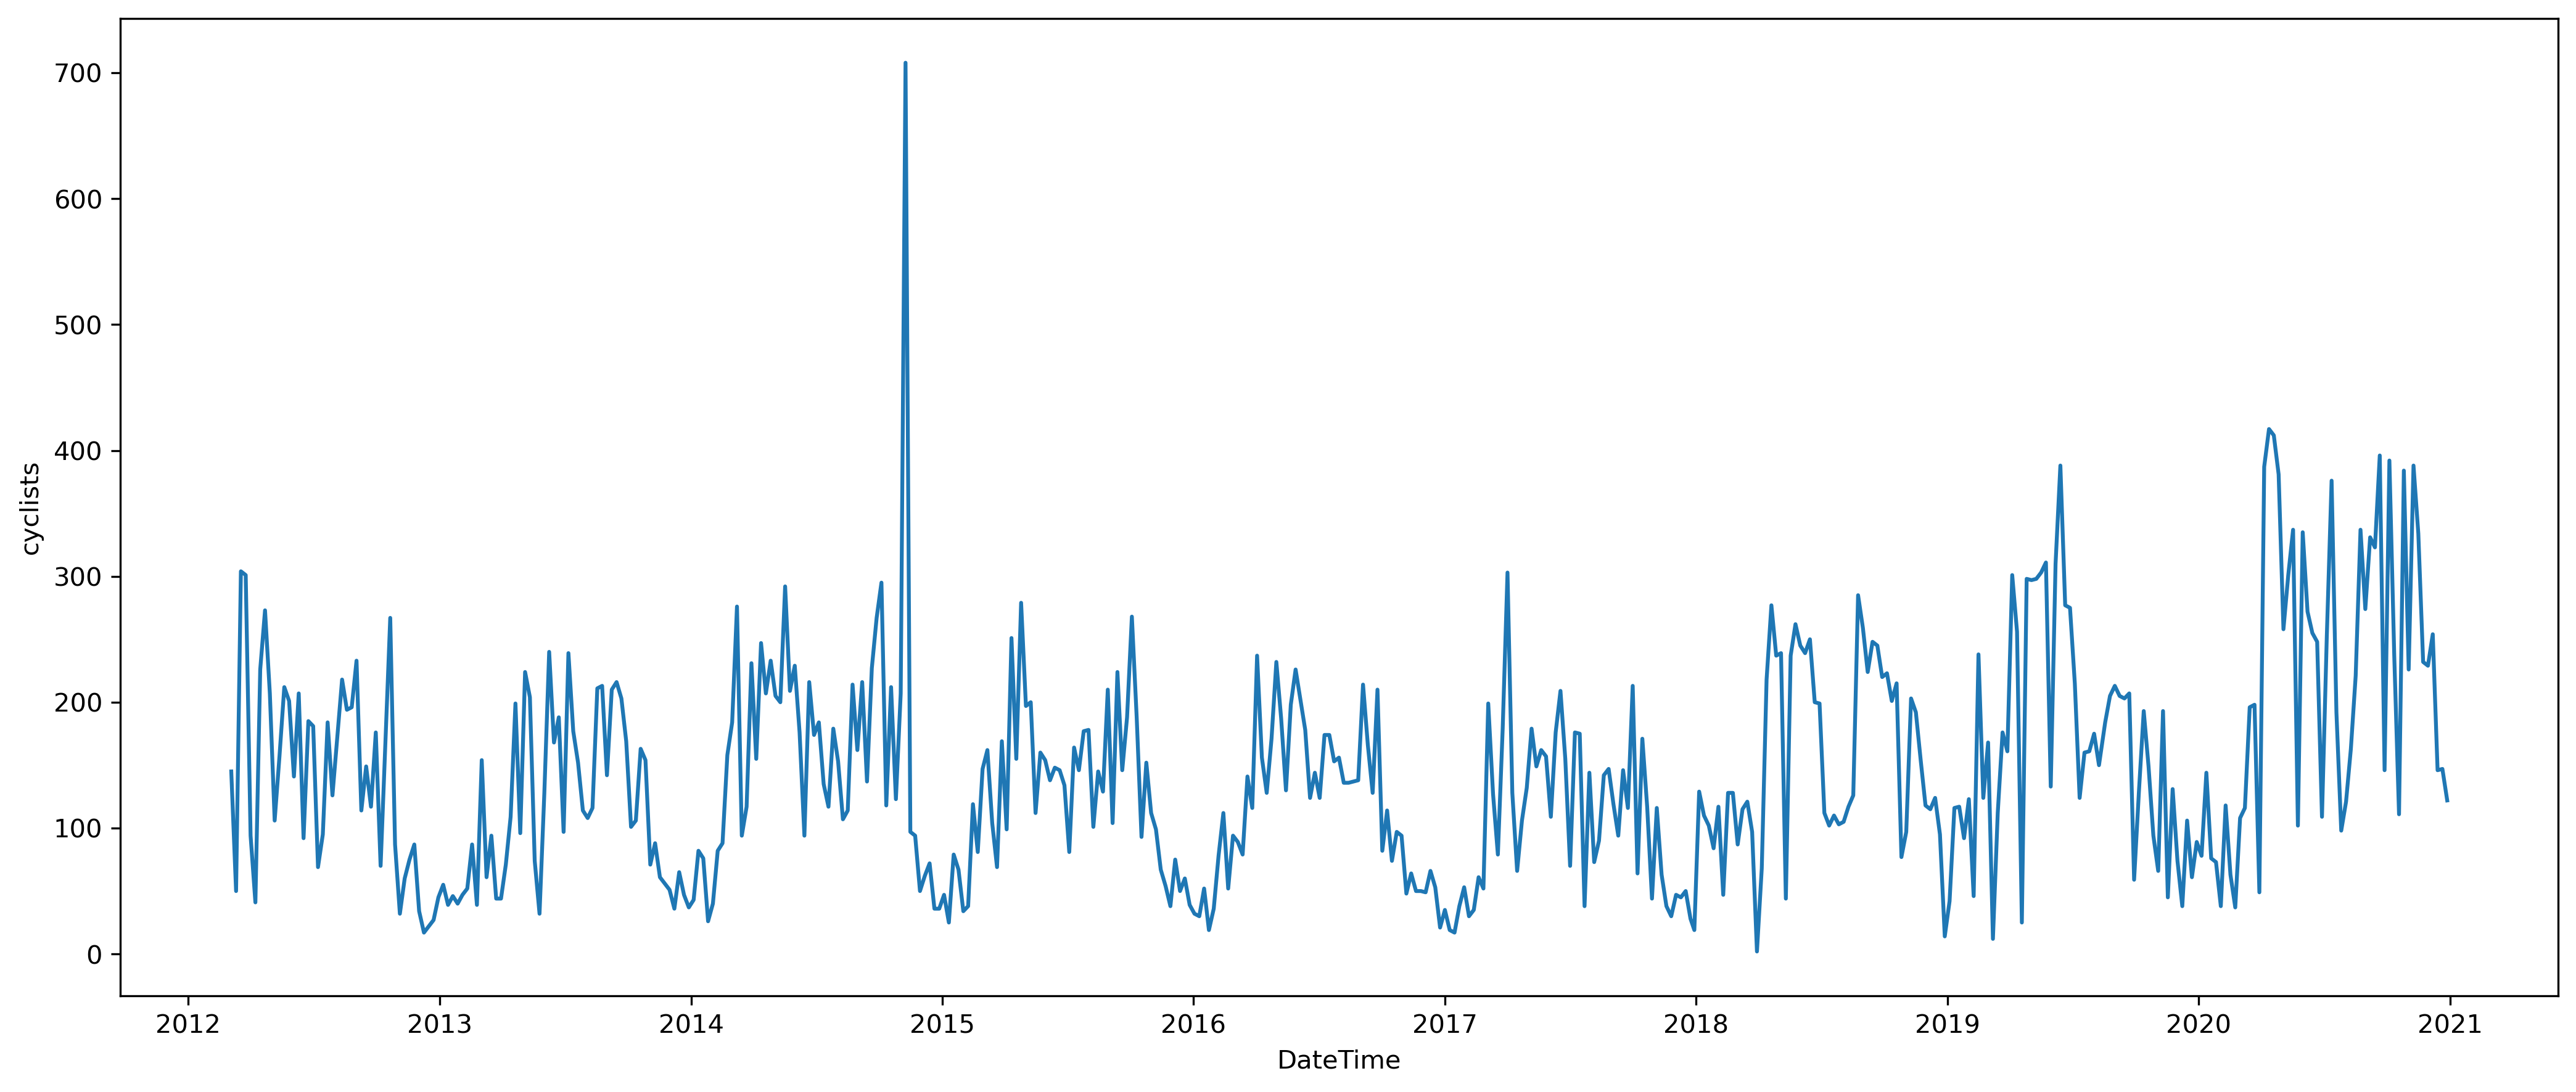

In [31]:
data_schw = data_augmented.loc[data_augmented["station"] == 'schw'][::(24*7)]
plt.figure(figsize=(17,7))
sns.lineplot(data=data_schw, y='cyclists', x='DateTime', estimator='mean')

Nevertheless, I want to use the regression model for explaining the output a bit. Therefore I use shapley values and the library SHAP. You can read more about shapley values [here](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

In [32]:
import shap

shap_explainer = shap.KernelExplainer(gbr.predict, test_X)
shap_values = shap_explainer.shap_values(test_X)

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  0%|          | 0/323 [00:00<?, ?it/s]X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
INFO:shap:num_full_subsets = 2
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
INFO:shap:phi = [-376.70189024   27.57584432   16.42466634   68.67558972 -407.37466167]
  0%|          | 1/323 [00:00<01:07,  4.75it/s]X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
INFO:shap:num_full_subsets = 2
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
INFO:shap:phi = [-372.59085249   34.94790166   16.44041686   68.76015631 -407.38017435]
  1%|          | 2/323 [00:00<01:07,  4.75it/s]X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
INFO:shap:num_full_subsets = 2
X does not have 

Unfortunately the shap plot is not that comfortable to read. That's why I decide to plot the legend first, so you can read the next plot more easily.

Text(0.5, 0, 'legend for numbers')

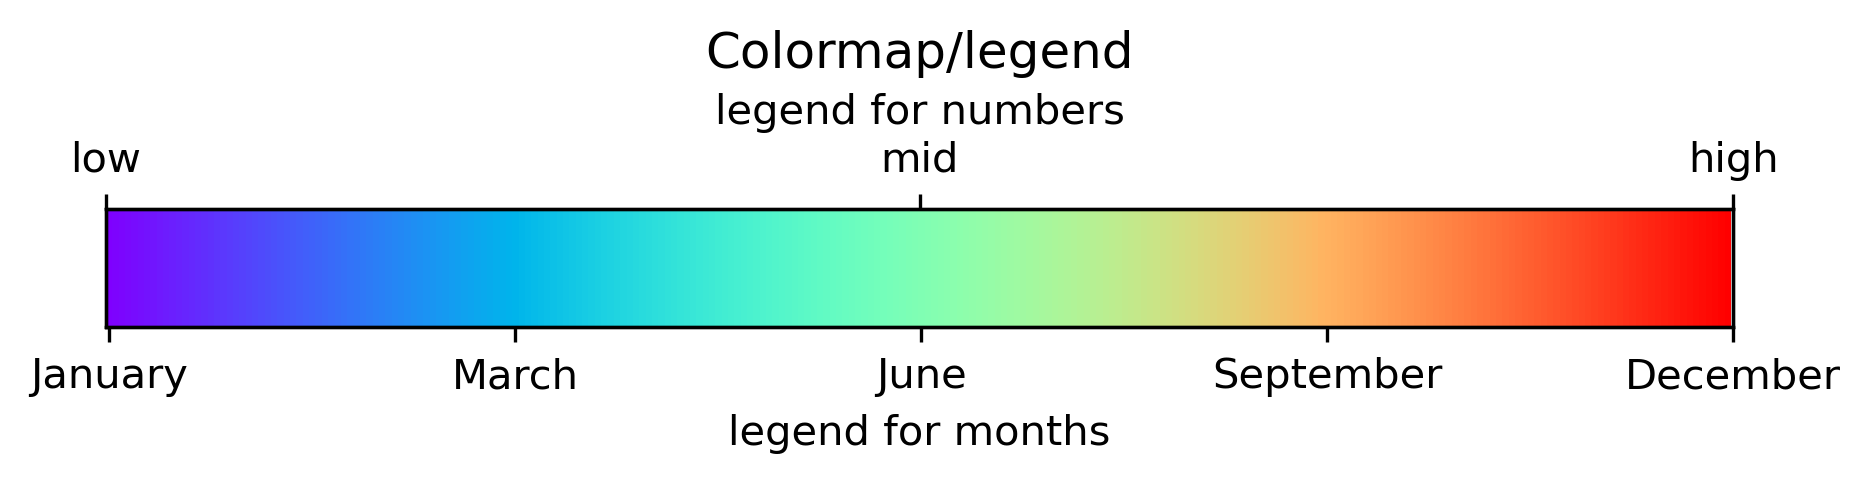

In [33]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

figh = 0.35 + 0.15 + (0.1) * 0.22
fig = plt.figure(figsize=(7, figh))
ax1 = fig.add_subplot(111)
ax1.set_title("Colormap/legend")
name = 'rainbow'
ax1.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
ax1.set_xlabel("legend for months")
ax1.set_xticks([0, (256/(12/3)), (256/(12/6)), (256/(12/9)), 256],["January", "March", "June", "September", "December"])
ax1.set_yticks([])

ax2 = ax1.twiny()
ax2.set_xticks([0, (256/2), 256],["low", "mid", "high"])
ax2.set_xlabel("legend for numbers")

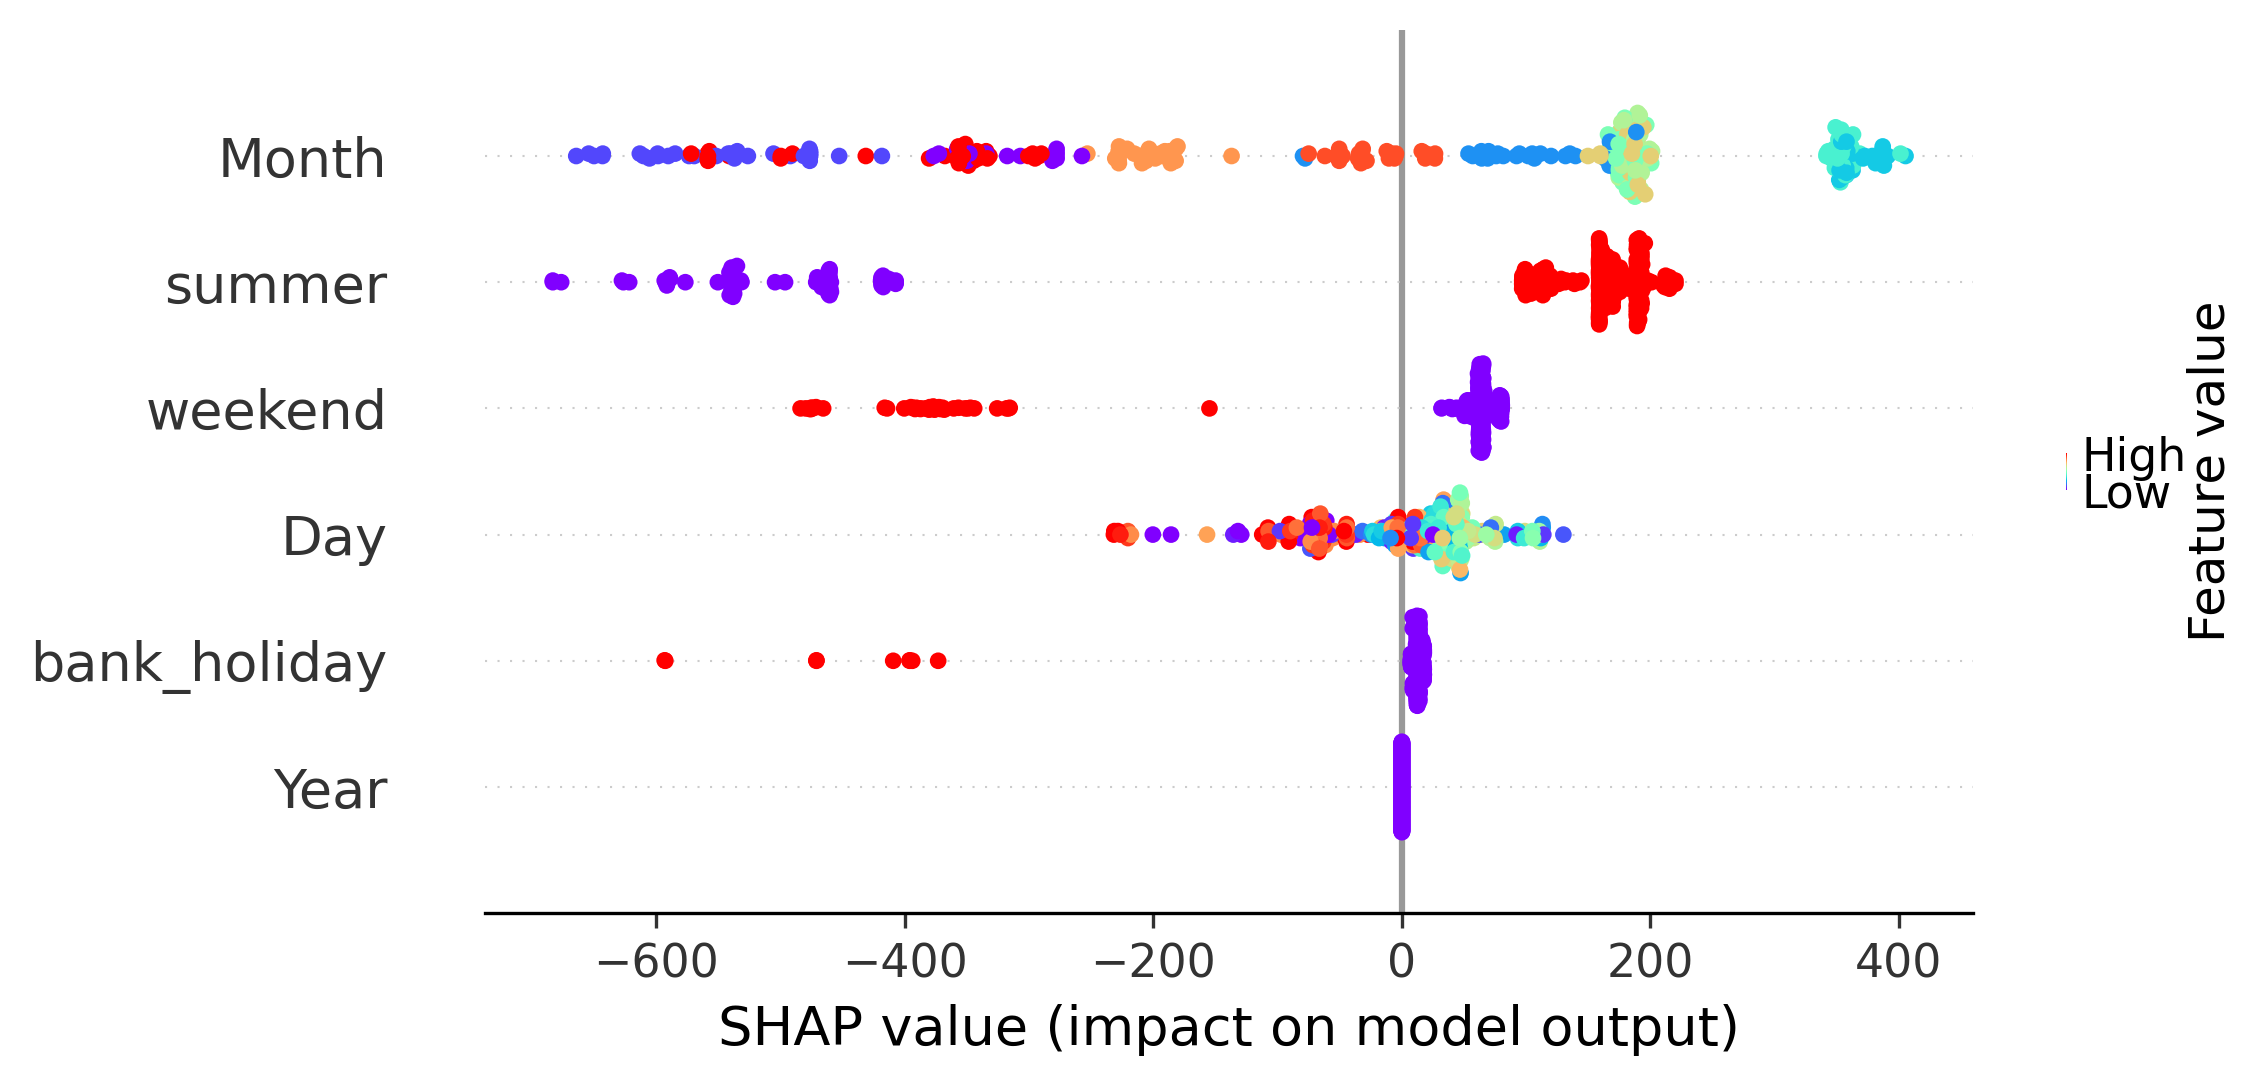

In [34]:
import matplotlib
shap.summary_plot(shap_values, test_X, alpha=1, 
                  cmap=plt.get_cmap('rainbow'))

### Here are my foundings out of this plot
- The months from March/April until August push the model answer positive (higher output values = model predicts more cyclists)
- There are more cyclists on the road in spring than in fall, as you can see there are defenitely more blue-ish and green-ish points (spring and summer months) than yellow-ish and red points.
- Fall and winter months (shown by very violett and red points) pull the number of cyclists down
- the summer variable supports the findings above: a high summer value (1 for encoding summer months) results in positive impact of the number of cyclists
- There are less cyclists at the weekend
- Bank holidays have a heavy negative impact on cyclists 
- The year has no significant impact on the prediction